### project 2

In [ ]:
# Interactive hand-period detector (Jupyter)
# Requires: pip install opencv-python ipywidgets matplotlib
# In JupyterLab you may also need: jupyter labextension install @jupyter-widgets/jupyterlab-manager

import cv2
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from dataclasses import dataclass
from typing import Optional, Tuple, List

# ----------------------------
# Core logic (same as script)
# ----------------------------

@dataclass
class Params:
    resize_width: int = 960
    blur_ksize: int = 9
    bg_alpha: float = 0.03
    diff_thresh: int = 25
    motion_open_ksize: int = 5
    skin_open_ksize: int = 5
    min_hand_ratio: float = 0.006
    warmup_frames: int = 30
    min_interval_s: float = 0.25
    merge_gap_s: float = 0.20

def resize_keep_aspect(frame: np.ndarray, width: int) -> np.ndarray:
    if width <= 0:
        return frame
    h, w = frame.shape[:2]
    if w == width:
        return frame
    scale = width / float(w)
    new_h = int(round(h * scale))
    return cv2.resize(frame, (width, new_h), interpolation=cv2.INTER_AREA)

def get_skin_mask_bgr(frame_bgr: np.ndarray, open_ksize: int,
                      h_lo=0, h_hi=25, s_lo=20, s_hi=255, v_lo=40, v_hi=255) -> np.ndarray:
    hsv = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2HSV)
    lower = np.array([h_lo, s_lo, v_lo], dtype=np.uint8)
    upper = np.array([h_hi, s_hi, v_hi], dtype=np.uint8)
    mask = cv2.inRange(hsv, lower, upper)
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (open_ksize, open_ksize))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, k, iterations=1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, k, iterations=1)
    return mask

def get_motion_mask(gray_blur: np.ndarray, bg_u8: np.ndarray, diff_thresh: int, open_ksize: int) -> np.ndarray:
    diff = cv2.absdiff(gray_blur, bg_u8)
    _, motion = cv2.threshold(diff, diff_thresh, 255, cv2.THRESH_BINARY)
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (open_ksize, open_ksize))
    motion = cv2.morphologyEx(motion, cv2.MORPH_OPEN, k, iterations=1)
    motion = cv2.morphologyEx(motion, cv2.MORPH_CLOSE, k, iterations=1)
    return motion

def decide_hand_present(hand_mask: np.ndarray, roi: Optional[Tuple[int,int,int,int]], min_ratio: float) -> bool:
    h, w = hand_mask.shape[:2]
    if roi is None:
        x, y, rw, rh = 0, 0, w, h
    else:
        x, y, rw, rh = roi
    x2 = max(0, min(w, x + rw))
    y2 = max(0, min(h, y + rh))
    x = max(0, min(w - 1, x))
    y = max(0, min(h - 1, y))
    crop = hand_mask[y:y2, x:x2]
    if crop.size == 0:
        return False
    ratio = float(np.count_nonzero(crop)) / float(crop.size)
    return ratio >= min_ratio

def booleans_to_intervals(flags: List[bool], fps: float) -> List[Tuple[float, float]]:
    intervals = []
    start = None
    for i, v in enumerate(flags):
        if v and start is None:
            start = i
        elif (not v) and start is not None:
            intervals.append((start / fps, i / fps))
            start = None
    if start is not None:
        intervals.append((start / fps, len(flags) / fps))
    return intervals

def merge_and_filter_intervals(intervals: List[Tuple[float, float]], min_len: float, merge_gap: float) -> List[Tuple[float, float]]:
    if not intervals:
        return []
    intervals = sorted(intervals, key=lambda x: x[0])
    merged = [intervals[0]]
    for s, e in intervals[1:]:
        ps, pe = merged[-1]
        if s - pe <= merge_gap:
            merged[-1] = (ps, max(pe, e))
        else:
            merged.append((s, e))
    merged = [(s, e) for (s, e) in merged if (e - s) >= min_len]
    return merged

def invert_intervals(total_s: float, intervals: List[Tuple[float, float]]) -> List[Tuple[float, float]]:
    if not intervals:
        return [(0.0, total_s)]
    intervals = sorted(intervals, key=lambda x: x[0])
    out = []
    cur = 0.0
    for s, e in intervals:
        if s > cur:
            out.append((cur, s))
        cur = max(cur, e)
    if cur < total_s:
        out.append((cur, total_s))
    return out

# ---------------------------------
# Video helpers + interactive UI
# ---------------------------------

class VideoReader:
    def __init__(self, video_path: str):
        self.video_path = video_path
        self.cap = cv2.VideoCapture(video_path)
        if not self.cap.isOpened():
            raise RuntimeError(f"Could not open video: {video_path}")
        self.fps = self.cap.get(cv2.CAP_PROP_FPS) or 30.0
        self.nframes = int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)

    def read_frame(self, idx: int):
        idx = max(0, min(self.nframes - 1, idx))
        self.cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ok, frame = self.cap.read()
        if not ok:
            return None
        return frame

    def release(self):
        self.cap.release()

def preview_at_frame(video: VideoReader, frame_idx: int, roi, p: Params,
                     hsv_bounds, show_roi=True):
    frame = video.read_frame(frame_idx)
    if frame is None:
        print("Could not read frame.")
        return

    frame = resize_keep_aspect(frame, p.resize_width)

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray_blur = cv2.GaussianBlur(gray, (p.blur_ksize, p.blur_ksize), 0)

    # Build a quick background estimate using a short window before the frame
    # (so preview works without scanning whole video)
    bg = None
    start = max(0, frame_idx - max(10, p.warmup_frames))
    for i in range(start, frame_idx + 1):
        fr = video.read_frame(i)
        if fr is None:
            continue
        fr = resize_keep_aspect(fr, p.resize_width)
        g = cv2.cvtColor(fr, cv2.COLOR_BGR2GRAY)
        g = cv2.GaussianBlur(g, (p.blur_ksize, p.blur_ksize), 0)
        if bg is None:
            bg = g.astype(np.float32)
        else:
            cv2.accumulateWeighted(g, bg, p.bg_alpha)
    if bg is None:
        print("Could not build background.")
        return

    bg_u8 = cv2.convertScaleAbs(bg)

    h_lo, h_hi, s_lo, s_hi, v_lo, v_hi = hsv_bounds
    skin = get_skin_mask_bgr(frame, p.skin_open_ksize, h_lo, h_hi, s_lo, s_hi, v_lo, v_hi)
    motion = get_motion_mask(gray_blur, bg_u8, p.diff_thresh, p.motion_open_ksize)
    hand_mask = cv2.bitwise_and(skin, motion)

    hand_present = decide_hand_present(hand_mask, roi, p.min_hand_ratio)

    # Draw ROI overlay on RGB preview
    preview = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB).copy()
    if show_roi and roi is not None:
        x, y, w, h = roi
        cv2.rectangle(preview, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Metrics
    if roi is None:
        crop = hand_mask
    else:
        x,y,w,h = roi
        crop = hand_mask[y:y+h, x:x+w] if (y+h <= hand_mask.shape[0] and x+w <= hand_mask.shape[1]) else hand_mask
    ratio = float(np.count_nonzero(crop)) / float(crop.size) if crop.size else 0.0

    # Plot
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    axs[0].imshow(preview); axs[0].set_title(f"Frame {frame_idx} (ROI shown)")
    axs[1].imshow(bg_u8, cmap="gray"); axs[1].set_title("Background estimate")
    axs[2].imshow(motion, cmap="gray"); axs[2].set_title("Motion mask")
    axs[3].imshow(hand_mask, cmap="gray"); axs[3].set_title("Hand mask = skin ∧ motion")
    for ax in axs: ax.axis("off")
    plt.show()

    print(f"hand_present={hand_present} | hand_ratio_in_roi={ratio:.6f} | threshold={p.min_hand_ratio:.6f}")

def scan_video_intervals(video_path: str, roi, p: Params, hsv_bounds, progress_cb=None):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise RuntimeError(f"Could not open video: {video_path}")
    fps = cap.get(cv2.CAP_PROP_FPS) or 30.0

    h_lo, h_hi, s_lo, s_hi, v_lo, v_hi = hsv_bounds

    hand_flags = []
    bg = None
    idx = 0

    nframes = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)

    while True:
        ok, frame = cap.read()
        if not ok:
            break

        frame = resize_keep_aspect(frame, p.resize_width)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gray_blur = cv2.GaussianBlur(gray, (p.blur_ksize, p.blur_ksize), 0)

        if bg is None:
            bg = gray_blur.copy().astype(np.float32)

        bg_u8 = cv2.convertScaleAbs(bg)

        skin = get_skin_mask_bgr(frame, p.skin_open_ksize, h_lo, h_hi, s_lo, s_hi, v_lo, v_hi)
        motion = get_motion_mask(gray_blur, bg_u8, p.diff_thresh, p.motion_open_ksize)
        hand_mask = cv2.bitwise_and(skin, motion)

        hand_present = decide_hand_present(hand_mask, roi, p.min_hand_ratio)
        hand_flags.append(hand_present)

        # background update rule
        if idx < p.warmup_frames or (not hand_present):
            cv2.accumulateWeighted(gray_blur, bg, p.bg_alpha)

        idx += 1
        if progress_cb and nframes > 0 and idx % 10 == 0:
            progress_cb(idx / nframes)

    cap.release()

    total_s = len(hand_flags) / fps
    hand_intervals = merge_and_filter_intervals(
        booleans_to_intervals(hand_flags, fps),
        p.min_interval_s,
        p.merge_gap_s
    )
    no_hand_intervals = merge_and_filter_intervals(
        invert_intervals(total_s, hand_intervals),
        p.min_interval_s,
        p.merge_gap_s
    )

    return {
        "fps": fps,
        "total_seconds": total_s,
        "hand_present_intervals": hand_intervals,
        "no_hand_intervals": no_hand_intervals,
    }

def plot_intervals(total_s, intervals, title):
    plt.figure(figsize=(12, 1.6))
    plt.title(title)
    plt.xlim(0, total_s)
    plt.ylim(0, 1)
    for (s, e) in intervals:
        plt.plot([s, e], [0.5, 0.5], linewidth=10)
    plt.yticks([])
    plt.xlabel("seconds")
    plt.show()

# ----------------------------
# Interactive widgets
# ----------------------------

video_path_w = widgets.Text(
    value="path/to/clip.mp4",
    description="Video:",
    layout=widgets.Layout(width="900px")
)

roi_enable_w = widgets.Checkbox(value=False, description="Use ROI")
roi_x_w = widgets.IntText(value=0, description="x")
roi_y_w = widgets.IntText(value=0, description="y")
roi_w_w = widgets.IntText(value=600, description="w")
roi_h_w = widgets.IntText(value=600, description="h")

frame_idx_w = widgets.IntSlider(value=0, min=0, max=100, step=1, description="Frame:")

resize_width_w = widgets.IntSlider(value=960, min=0, max=1920, step=10, description="resize_w")
blur_ksize_w = widgets.IntSlider(value=9, min=3, max=31, step=2, description="blur_k")
bg_alpha_w = widgets.FloatSlider(value=0.03, min=0.001, max=0.2, step=0.001, readout_format=".3f", description="bg_alpha")
diff_thresh_w = widgets.IntSlider(value=25, min=1, max=80, step=1, description="diff_th")
min_hand_ratio_w = widgets.FloatSlider(value=0.006, min=0.0005, max=0.05, step=0.0005, readout_format=".4f", description="hand_ratio")

motion_open_w = widgets.IntSlider(value=5, min=1, max=21, step=2, description="mot_k")
skin_open_w = widgets.IntSlider(value=5, min=1, max=21, step=2, description="skin_k")
warmup_frames_w = widgets.IntSlider(value=30, min=0, max=200, step=1, description="warmup")

# HSV bounds (tune if needed)
h_lo_w = widgets.IntSlider(value=0, min=0, max=179, step=1, description="H lo")
h_hi_w = widgets.IntSlider(value=25, min=0, max=179, step=1, description="H hi")
s_lo_w = widgets.IntSlider(value=20, min=0, max=255, step=1, description="S lo")
s_hi_w = widgets.IntSlider(value=255, min=0, max=255, step=1, description="S hi")
v_lo_w = widgets.IntSlider(value=40, min=0, max=255, step=1, description="V lo")
v_hi_w = widgets.IntSlider(value=255, min=0, max=255, step=1, description="V hi")

preview_btn = widgets.Button(description="Preview this frame", button_style="info")
scan_btn = widgets.Button(description="Scan whole video", button_style="success")
out = widgets.Output()

progress = widgets.FloatProgress(value=0.0, min=0.0, max=1.0, description="Scan:")
progress.layout.width = "600px"

def current_roi():
    if not roi_enable_w.value:
        return None
    return (roi_x_w.value, roi_y_w.value, roi_w_w.value, roi_h_w.value)

def current_params():
    return Params(
        resize_width=resize_width_w.value,
        blur_ksize=blur_ksize_w.value,
        bg_alpha=bg_alpha_w.value,
        diff_thresh=diff_thresh_w.value,
        motion_open_ksize=motion_open_w.value,
        skin_open_ksize=skin_open_w.value,
        min_hand_ratio=min_hand_ratio_w.value,
        warmup_frames=warmup_frames_w.value,
    )

def current_hsv_bounds():
    return (h_lo_w.value, h_hi_w.value, s_lo_w.value, s_hi_w.value, v_lo_w.value, v_hi_w.value)

def update_frame_slider_max():
    try:
        vr = VideoReader(video_path_w.value)
        frame_idx_w.max = max(0, vr.nframes - 1)
        frame_idx_w.value = min(frame_idx_w.value, frame_idx_w.max)
        vr.release()
    except Exception as e:
        with out:
            print("Could not open video to set frame slider:", e)

video_path_w.observe(lambda change: update_frame_slider_max(), names="value")

def on_preview(_):
    out.clear_output()
    try:
        vr = VideoReader(video_path_w.value)
        with out:
            preview_at_frame(
                vr,
                frame_idx_w.value,
                current_roi(),
                current_params(),
                current_hsv_bounds(),
                show_roi=True
            )
        vr.release()
    except Exception as e:
        with out:
            print("Preview error:", e)

def on_scan(_):
    out.clear_output()
    progress.value = 0.0
    try:
        def cb(v):
            progress.value = v
        result = scan_video_intervals(
            video_path_w.value,
            current_roi(),
            current_params(),
            current_hsv_bounds(),
            progress_cb=cb
        )
        progress.value = 1.0

        with out:
            print("Hand present intervals:")
            for s, e in result["hand_present_intervals"]:
                print(f"  {s:.2f} - {e:.2f} s")
            print("\nNo-hand intervals (use for later processing):")
            for s, e in result["no_hand_intervals"]:
                print(f"  {s:.2f} - {e:.2f} s")

            plot_intervals(result["total_seconds"], result["hand_present_intervals"], "Hand present (timeline)")
            plot_intervals(result["total_seconds"], result["no_hand_intervals"], "No-hand (timeline)")

            # Keep the result available in the notebook
            global HAND_DETECT_RESULT
            HAND_DETECT_RESULT = result
            print("\nSaved in variable: HAND_DETECT_RESULT")

    except Exception as e:
        with out:
            print("Scan error:", e)

preview_btn.on_click(on_preview)
scan_btn.on_click(on_scan)

ui = widgets.VBox([
    video_path_w,
    widgets.HBox([frame_idx_w, preview_btn]),
    widgets.HBox([roi_enable_w, roi_x_w, roi_y_w, roi_w_w, roi_h_w]),
    widgets.HBox([resize_width_w, blur_ksize_w, warmup_frames_w]),
    widgets.HBox([bg_alpha_w, diff_thresh_w, min_hand_ratio_w]),
    widgets.HBox([motion_open_w, skin_open_w]),
    widgets.Label("HSV skin bounds (tune if lighting/skin tone differs):"),
    widgets.HBox([h_lo_w, h_hi_w, s_lo_w, s_hi_w, v_lo_w, v_hi_w]),
    widgets.HBox([scan_btn, progress]),
    out
])

display(ui)
update_frame_slider_max()


In [1]:
print("ready to work!")

ready to work!


In [3]:
import sys, json
import cv2
import numpy as np

# sys.path.append("/mnt/data")
import detect_board as db  # :contentReference[oaicite:2]{index=2}

HAND_JSON = "outputs/hand_periods.json"  # :contentReference[oaicite:3]{index=3}

# --- load video + pick a timestamp inside a no-hand interval
with open(HAND_JSON, "r", encoding="utf-8") as f:
    hp = json.load(f)

VIDEO_PATH = hp["video"]
no_hand = hp["no_hand_intervals"]
t0, t1 = no_hand[0]
t_pick = (t0 + t1) / 2.0  # middle of first no-hand window

# --- open video and grab one frame at t_pick
cap = cv2.VideoCapture(VIDEO_PATH)
cap.set(cv2.CAP_PROP_POS_MSEC, t_pick * 1000.0)
ok, frame = cap.read()
cap.release()
if not ok:
    raise RuntimeError("Could not read frame")

# --- config (tune if needed)
cfg = db.CalibCFG(video_path=VIDEO_PATH, warp_size=900, show_debug=False, save_debug=False)

# --- detect quad -> H -> warp -> inner box -> fields
quad = db.find_board_quad(frame, cfg)
if quad is None:
    raise RuntimeError("Board quad not found on this frame. Try another no-hand interval or tune Canny/area params.")

s = cfg.warp_size
dst = np.array([[0, 0], [s-1, 0], [s-1, s-1], [0, s-1]], dtype=np.float32)
H = cv2.getPerspectiveTransform(quad.astype(np.float32), dst)

warped = db.warp_board(frame, H, s)

inner_box = db.inner_box_from_edge_profiles(
    warped,
    band_ratio=cfg.band_ratio,
    smooth_ksize=cfg.smooth_ksize,
    min_margin_ratio=cfg.min_margin_ratio,
)
if inner_box is None:
    raise RuntimeError("Inner box not found on this frame. Try another frame or tune band_ratio/smooth_ksize.")

fields, meta = db.build_monopoly_fields_robust(s, inner_box)

# --- draw overlay on warped
overlay = warped.copy()
xl, yt, xr, yb = inner_box
cv2.rectangle(overlay, (xl, yt), (xr, yb), (0, 255, 0), 2)   # inner box
for (x1, y1, x2, y2) in fields:
    cv2.rectangle(overlay, (x1, y1), (x2, y2), (255, 0, 0), 2)  # fields

out_path = "frame_overlay.png"
cv2.imwrite(out_path, overlay)
print("Saved:", out_path)


Saved: frame_overlay.png


### generates the video with hand detected or not labes

In [ ]:
import sys, json
import cv2
import numpy as np

sys.path.append("/mnt/data")
import detect_board as db  # :contentReference[oaicite:1]{index=1}

HAND_JSON = "hand_periods.json"  # 
OUT_MP4 = "board_overlay_warped_with_hand_text.mp4"

# ---- load intervals
with open(HAND_JSON, "r", encoding="utf-8") as f:
    hp = json.load(f)

# VIDEO_PATH = hp["video"]

VIDEO_PATH = "data/easy/4_easy.mp4"
hand_intervals = [(float(a), float(b)) for (a, b) in hp.get("hand_intervals", []) if b > a]
no_hand_intervals = [(float(a), float(b)) for (a, b) in hp.get("no_hand_intervals", []) if b > a]

# ---- helper: O(#intervals) check (fine for typical sizes)
def in_any_interval(t_s, intervals):
    for a, b in intervals:
        if a <= t_s <= b:
            return True
    return False

def hand_state_at(t_s):
    # prefer hand_intervals; if missing, infer from no_hand
    if hand_intervals:
        return in_any_interval(t_s, hand_intervals)
    if no_hand_intervals:
        return not in_any_interval(t_s, no_hand_intervals)
    return False  # fallback

# ---- config
cfg = db.CalibCFG(video_path=VIDEO_PATH, warp_size=900, show_debug=False, save_debug=False)
s = cfg.warp_size

# local stride (avoid cfg.board_stride mismatch)
STRIDE = 2

def set_time(cap, t_s):
    cap.set(cv2.CAP_PROP_POS_MSEC, t_s * 1000.0)

# =========================
# 1) CALIBRATION from no-hand (recommended)
# =========================
if not no_hand_intervals:
    raise RuntimeError("No no_hand_intervals in hand_periods.json. Re-run detect_hand or include no-hand intervals.")

# 1a) median quad -> H
cap = cv2.VideoCapture(VIDEO_PATH)
quads = []
target_quads = getattr(cfg, "board_sample_frames", 80)

for (t0, t1) in no_hand_intervals:
    if len(quads) >= target_quads:
        break
    set_time(cap, t0)
    i = 0
    while cap.get(cv2.CAP_PROP_POS_MSEC) < t1 * 1000.0 and len(quads) < target_quads:
        ok, frame = cap.read()
        if not ok:
            break
        if i % STRIDE == 0:
            q = db.find_board_quad(frame, cfg)
            if q is not None:
                quads.append(q)
        i += 1

cap.release()

if len(quads) < max(10, target_quads // 4):
    raise RuntimeError(f"Too few quads from no-hand intervals: {len(quads)}. Tune params or STRIDE.")

quad_med = np.median(np.stack(quads, axis=0), axis=0).astype(np.float32)
dst = np.array([[0, 0], [s-1, 0], [s-1, s-1], [0, s-1]], dtype=np.float32)
H = cv2.getPerspectiveTransform(quad_med, dst)

# 1b) median inner box
cap = cv2.VideoCapture(VIDEO_PATH)
boxes = []
target_boxes = getattr(cfg, "inner_sample_frames", 70)

for (t0, t1) in no_hand_intervals:
    if len(boxes) >= target_boxes:
        break
    set_time(cap, t0)
    i = 0
    while cap.get(cv2.CAP_PROP_POS_MSEC) < t1 * 1000.0 and len(boxes) < target_boxes:
        ok, frame = cap.read()
        if not ok:
            break
        if i % STRIDE == 0:
            warped = db.warp_board(frame, H, s)
            b = db.inner_box_from_edge_profiles(
                warped,
                band_ratio=getattr(cfg, "band_ratio", 0.30),
                smooth_ksize=getattr(cfg, "smooth_ksize", 51),
                min_margin_ratio=getattr(cfg, "min_margin_ratio", 0.06),
            )
            if b is not None:
                boxes.append(b)
        i += 1

cap.release()

if len(boxes) < max(10, target_boxes // 4):
    raise RuntimeError(f"Too few inner boxes: {len(boxes)}. Try STRIDE=1 or tune band_ratio/smooth_ksize.")

inner_box = tuple(int(round(x)) for x in np.median(np.array(boxes, np.float32), axis=0))
fields, meta = db.build_monopoly_fields_robust(s, inner_box)

print("Calibration OK")
print("  inner_box:", inner_box)

# =========================
# 2) PROCESS FULL VIDEO -> overlay output (warped) + HAND TEXT
# =========================
cap = cv2.VideoCapture(VIDEO_PATH)
fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
writer = cv2.VideoWriter(OUT_MP4, fourcc, fps, (s, s))

xl, yt, xr, yb = inner_box
font = cv2.FONT_HERSHEY_SIMPLEX

while True:
    ok, frame = cap.read()
    if not ok:
        break

    # current timestamp (seconds)
    t_ms = cap.get(cv2.CAP_PROP_POS_MSEC)
    t_s = t_ms / 1000.0

    warped = db.warp_board(frame, H, s)
    overlay = warped.copy()

    # draw inner box + 40 fields
    cv2.rectangle(overlay, (xl, yt), (xr, yb), (0, 255, 0), 2)
    for (x1, y1, x2, y2) in fields:
        cv2.rectangle(overlay, (x1, y1), (x2, y2), (255, 0, 0), 2)

    # hand label
    is_hand = hand_state_at(t_s)
    label = "HAND DETECTED" if is_hand else "HAND NOT DETECTED"
    color = (0, 0, 255) if is_hand else (0, 255, 0)

    # optional: show timestamp
    ts = f"{t_s:8.2f}s"

    # draw text with a black outline for readability
    x, y = 15, 35
    cv2.putText(overlay, label, (x, y), font, 1.0, (0, 0, 0), 4, cv2.LINE_AA)
    cv2.putText(overlay, label, (x, y), font, 1.0, color, 2, cv2.LINE_AA)

    cv2.putText(overlay, ts, (x, y + 32), font, 0.8, (0, 0, 0), 4, cv2.LINE_AA)
    cv2.putText(overlay, ts, (x, y + 32), font, 0.8, (255, 255, 255), 2, cv2.LINE_AA)

    writer.write(overlay)

cap.release()
writer.release()

print("Saved:", OUT_MP4)


### check masks

In [4]:
import sys, json
import cv2
import numpy as np

sys.path.append("/mnt/data")
import detect_board as db  # :contentReference[oaicite:1]{index=1}

HAND_JSON = "outputs/hand_periods.json"  # 

# -----------------------
# Load intervals + video
# -----------------------
with open(HAND_JSON, "r", encoding="utf-8") as f:
    hp = json.load(f)

VIDEO_PATH = "data/easy/4_easy.mp4"
no_hand = [(float(a), float(b)) for (a, b) in hp["no_hand_intervals"] if b > a]
if not no_hand:
    raise RuntimeError("No no_hand_intervals found in hand_periods.json")

# -----------------------
# Config + helpers
# -----------------------
cfg = db.CalibCFG(video_path=VIDEO_PATH, warp_size=900, show_debug=False, save_debug=False)
s = cfg.warp_size
STRIDE = 2  # local stride, independent of cfg

def set_time(cap, t_s):
    cap.set(cv2.CAP_PROP_POS_MSEC, t_s * 1000.0)

# -----------------------
# Calibrate: median quad -> H
# -----------------------
cap = cv2.VideoCapture(VIDEO_PATH)
target_quads = getattr(cfg, "board_sample_frames", 80)
quads = []

for (t0, t1) in no_hand:
    if len(quads) >= target_quads:
        break
    set_time(cap, t0)
    i = 0
    while cap.get(cv2.CAP_PROP_POS_MSEC) < t1 * 1000.0 and len(quads) < target_quads:
        ok, frame = cap.read()
        if not ok:
            break
        if i % STRIDE == 0:
            q = db.find_board_quad(frame, cfg)
            if q is not None:
                quads.append(q)
        i += 1

cap.release()
if len(quads) < max(10, target_quads // 4):
    raise RuntimeError(f"Too few quads: {len(quads)}")

quad_med = np.median(np.stack(quads, axis=0), axis=0).astype(np.float32)
dst = np.array([[0, 0], [s-1, 0], [s-1, s-1], [0, s-1]], dtype=np.float32)
H = cv2.getPerspectiveTransform(quad_med, dst)

# -----------------------
# Calibrate: median inner box
# -----------------------
cap = cv2.VideoCapture(VIDEO_PATH)
target_boxes = getattr(cfg, "inner_sample_frames", 70)
boxes = []

for (t0, t1) in no_hand:
    if len(boxes) >= target_boxes:
        break
    set_time(cap, t0)
    i = 0
    while cap.get(cv2.CAP_PROP_POS_MSEC) < t1 * 1000.0 and len(boxes) < target_boxes:
        ok, frame = cap.read()
        if not ok:
            break
        if i % STRIDE == 0:
            warped = db.warp_board(frame, H, s)
            b = db.inner_box_from_edge_profiles(
                warped,
                band_ratio=getattr(cfg, "band_ratio", 0.30),
                smooth_ksize=getattr(cfg, "smooth_ksize", 51),
                min_margin_ratio=getattr(cfg, "min_margin_ratio", 0.06),
            )
            if b is not None:
                boxes.append(b)
        i += 1

cap.release()
if len(boxes) < max(10, target_boxes // 4):
    raise RuntimeError(f"Too few inner boxes: {len(boxes)}")

inner_box = tuple(int(round(x)) for x in np.median(np.array(boxes, np.float32), axis=0))
print("inner_box:", inner_box)

# -----------------------
# Build masks (inner + ring)
# -----------------------
outer_mask, inner_mask, ring_mask, dice_roi, dice_roi_mask = db.build_masks(s, inner_box)

# Save masks as images (white=255, black=0)
cv2.imwrite("inner_mask.png", inner_mask)
cv2.imwrite("ring_mask.png", ring_mask)
print("Saved: inner_mask.png, ring_mask.png")

# -----------------------
# Optional sanity check overlay on one warped frame
# -----------------------
# Grab one frame from the first no-hand interval
cap = cv2.VideoCapture(VIDEO_PATH)
t0, t1 = no_hand[0]
set_time(cap, (t0 + t1) / 2.0)
ok, frame = cap.read()
cap.release()
if ok:
    warped = db.warp_board(frame, H, s)

    # visualize masks as translucent overlays
    overlay = warped.copy()
    # colorize inner mask in green-ish, ring in red-ish (simple)
    inner_color = np.zeros_like(overlay); inner_color[..., 1] = 255
    ring_color  = np.zeros_like(overlay); ring_color[..., 2] = 255

    alpha = 0.35
    overlay = np.where(inner_mask[..., None] > 0, (overlay*(1-alpha) + inner_color*alpha).astype(np.uint8), overlay)
    overlay = np.where(ring_mask[..., None]  > 0, (overlay*(1-alpha) + ring_color*alpha ).astype(np.uint8), overlay)

    cv2.imwrite("masks_overlay_on_warped.png", overlay)
    print("Saved: masks_overlay_on_warped.png")
else:
    print("Could not read a sample frame for overlay preview.")


inner_box: (124, 126, 777, 776)
Saved: inner_mask.png, ring_mask.png
Saved: masks_overlay_on_warped.png


### detect pawns on the frame

/home/chupakabra/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


warp_size: 900
inner_box: (124, 126, 777, 776)
Loaded bg_clean: warped_board_clean.png
Pawn threshold used: 81
Detected pawns: [((836.5, 440.5), 609)]


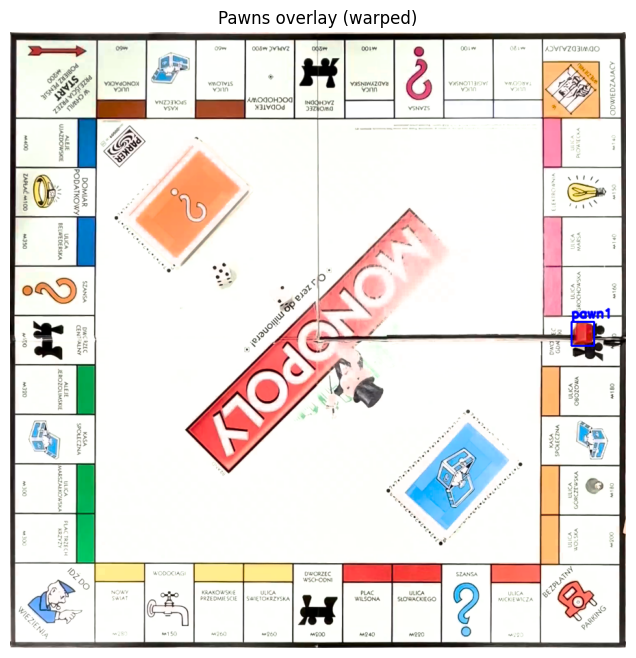

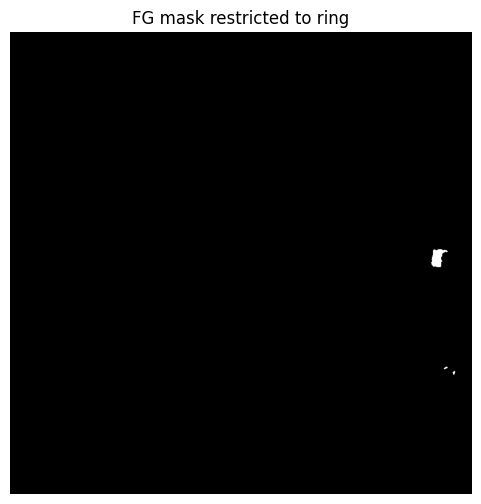

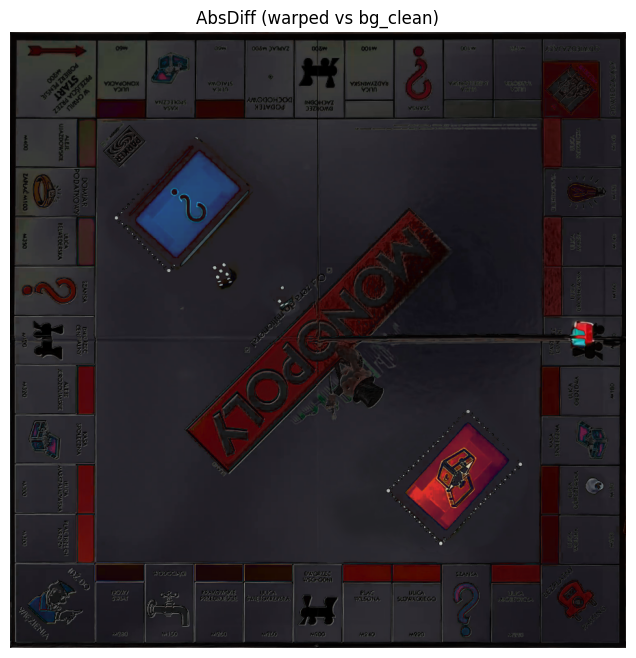

In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from detect_board import (
    CalibCFG,
    estimate_homography,
    estimate_inner_box_median,
    build_masks,
    load_warped_bg_clean,
    diff_warped_vs_bg_clean,
    warp_board,
    sample_frames,
)
from detect_pawns import detect_pawns_from_diff, PawnCFG


# ----------------------------
# 0) Set paths + warp size
# ----------------------------
VIDEO_PATH = "data/easy/2_easy.mp4"          # <-- change this
WARP_SIZE  = 900                             # <-- change if you want
BG_CLEAN_PATH = "warped_board_clean.png"     # warped clean background (BGR)


# ----------------------------
# helpers
# ----------------------------
def show(img, title="", figsize=(7, 7)):
    plt.figure(figsize=figsize)
    if img.ndim == 2:
        plt.imshow(img, cmap="gray")
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

def draw_bbox(img_bgr, bb, color=(255, 0, 0), label=None):
    x1, y1, x2, y2 = bb
    out = img_bgr.copy()
    cv2.rectangle(out, (x1, y1), (x2, y2), color, 2)
    if label is not None:
        cv2.putText(out, label, (x1, max(12, y1 - 6)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2, cv2.LINE_AA)
    return out


# ----------------------------
# 1) Calibrate: H + inner_box + ring_mask
# ----------------------------
cfg = CalibCFG(video_path=VIDEO_PATH, warp_size=WARP_SIZE, show_debug=False)

H, quad_med = estimate_homography(VIDEO_PATH, cfg)              # homography to warped board
inner_box = estimate_inner_box_median(VIDEO_PATH, H, cfg)       # inner square bounds in warped coords

outer_mask, inner_mask, ring_mask, dice_roi, dice_roi_mask = build_masks(cfg.warp_size, inner_box)

print("warp_size:", cfg.warp_size)
print("inner_box:", inner_box)


# ----------------------------
# 2) Load bg_clean (warped) OR build a quick median bg if missing
# ----------------------------
if os.path.exists(BG_CLEAN_PATH):
    bg_clean_bgr = load_warped_bg_clean(BG_CLEAN_PATH, cfg.warp_size)
    print("Loaded bg_clean:", BG_CLEAN_PATH)
else:
    print("bg_clean not found. Building a quick median warped background...")
    frames = sample_frames(VIDEO_PATH, n=50, stride=10)  # adjust if needed
    warped_stack = []
    for f in frames:
        w = warp_board(f, H, cfg.warp_size)
        warped_stack.append(w.astype(np.float32))
    bg_clean_bgr = np.median(np.stack(warped_stack, axis=0), axis=0).clip(0, 255).astype(np.uint8)
    cv2.imwrite(BG_CLEAN_PATH, bg_clean_bgr)
    print("Saved bg_clean to:", BG_CLEAN_PATH)


# ----------------------------
# 3) Read a frame + compute diff in warped space
# ----------------------------
cap = cv2.VideoCapture(VIDEO_PATH)
ok, frame_bgr = cap.read()
cap.release()
if not ok:
    raise RuntimeError("Could not read first frame from video.")

diff_bgr, _ = diff_warped_vs_bg_clean(
    frame_bgr=frame_bgr,
    H=H,
    warp_size=cfg.warp_size,
    bg_clean_bgr=bg_clean_bgr,
    to_gray=False,
    return_stats=False
)

# (Optional) also compute warped frame for overlay visualization
warped = warp_board(frame_bgr, H, cfg.warp_size)


# ----------------------------
# 4) Detect pawns from (diff + ring_mask) only
# ----------------------------
pawn_cfg = PawnCFG()  # tweak thresholds/morphology here if needed
pawns, fg_ring, dbg = detect_pawns_from_diff(
    diff_frame=diff_bgr,
    ring_mask=ring_mask,
    prev_centers=None,
    cfg=pawn_cfg
)

print("Pawn threshold used:", dbg["thr"])
print("Detected pawns:", [(p["center"], p["area"]) for p in pawns])


# ----------------------------
# 5) Visualize
# ----------------------------
vis = warped.copy()
for i, p in enumerate(pawns, 1):
    vis = draw_bbox(vis, p["bbox"], (255, 0, 0), label=f"pawn{i}")

show(vis, "Pawns overlay (warped)", figsize=(8, 8))
show(fg_ring, "FG mask restricted to ring", figsize=(6, 6))
show(diff_bgr, "AbsDiff (warped vs bg_clean)", figsize=(8, 8))
# show(ring_mask, "ring_mask", figsize=(6, 6))


### generates video with detected pawns

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

from detect_board import warp_board, diff_warped_vs_bg_clean
from detect_pawns import detect_pawns_from_diff, PawnCFG


# ----------------------------
# Config for full-video run
# ----------------------------
OUT_MP4 = "pawns_overlay.mp4"   # set None to disable saving
DISPLAY_EVERY = 5              # show every Nth frame (lower = slower)
MAX_FRAMES = None              # e.g. 500 to limit, or None for full video

pawn_cfg = PawnCFG()
prev_centers = None


def draw_pawn(img_bgr, pawn, color=(255, 0, 0), label="pawn"):
    x1, y1, x2, y2 = pawn["bbox"]
    cx, cy = pawn["center"]
    out = img_bgr
    cv2.rectangle(out, (x1, y1), (x2, y2), color, 2)
    cv2.circle(out, (int(cx), int(cy)), 4, color, -1)
    cv2.putText(out, label, (x1, max(12, y1 - 6)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2, cv2.LINE_AA)
    return out

VIDEO_PATH = "data/easy/3_easy.mp4"
cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    raise RuntimeError(f"Could not open: {VIDEO_PATH}")

fps = cap.get(cv2.CAP_PROP_FPS) or 25.0
W = int(cfg.warp_size)
Hh = int(cfg.warp_size)

writer = None
if OUT_MP4 is not None:
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer = cv2.VideoWriter(OUT_MP4, fourcc, fps, (W, Hh))

frame_i = 0
shown = 0

while True:
    ok, frame_bgr = cap.read()
    if not ok:
        break

    # 1) diff in warped space (BGR)
    diff_bgr, _ = diff_warped_vs_bg_clean(
        frame_bgr=frame_bgr,
        H=H,
        warp_size=cfg.warp_size,
        bg_clean_bgr=bg_clean_bgr,
        to_gray=False,
        return_stats=False
    )

    # 2) pawn detection uses ONLY (diff + ring_mask)
    pawns, fg_ring, dbg = detect_pawns_from_diff(
        diff_frame=diff_bgr,
        ring_mask=ring_mask,
        prev_centers=prev_centers,
        cfg=pawn_cfg
    )

    # update tracker centers for identity stability
    prev_centers = [p["center"] for p in pawns] if len(pawns) else prev_centers

    # 3) warp frame for visualization overlay
    warped = warp_board(frame_bgr, H, cfg.warp_size)
    vis = warped.copy()

    # label consistently by list order (kept stable via prev_centers matching)
    if len(pawns) >= 1:
        vis = draw_pawn(vis, pawns[0], color=(255, 0, 0), label="pawn1")
    if len(pawns) >= 2:
        vis = draw_pawn(vis, pawns[1], color=(0, 255, 0), label="pawn2")

    # add threshold readout
    cv2.putText(vis, f"thr={dbg['thr']}  frame={frame_i}",
                (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2, cv2.LINE_AA)

    # save
    if writer is not None:
        writer.write(vis)   

    frame_i += 1
    if MAX_FRAMES is not None and frame_i >= MAX_FRAMES:
        break

cap.release()
if writer is not None:
    writer.release()

print("Done.")
if OUT_MP4 is not None:
    print("Saved:", OUT_MP4)


### detects cards on the frame

In [ ]:
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt

from detect_board import load_warped_bg_clean, warp_frame, diff_warped_vs_bg_clean, build_masks
from detect_cards import detect_cards_from_diff, draw_minarearect, CardDetectCFG

# --- paths (adjust if needed) ---
FIELDS_JSON = "fields_coords.json"        # produced by working.py
BG_CLEAN_PATH = "warped_board_clean.png"  # your clean warped background
VIDEO_PATH = "data/easy/2_easy.mp4"

# --- load calibration payload saved by working.py ---
with open(FIELDS_JSON, "r", encoding="utf-8") as f:
    payload = json.load(f)

warp_size = int(payload["warp_size"])
H = np.array(payload["H"], dtype=np.float32)
inner_box = tuple(int(v) for v in payload["inner_box"])

# --- build masks ---
outer_mask, inner_mask, ring_mask, dice_roi, dice_roi_mask = build_masks(warp_size, inner_box)

# --- load background ---
bg_clean = load_warped_bg_clean(BG_CLEAN_PATH, warp_size)

# --- read one frame ---
cap = cv2.VideoCapture(VIDEO_PATH)
ok, frame = cap.read()
cap.release()
if not ok:
    raise RuntimeError("Could not read a frame from the video")

# --- warp frame + diff ---
warped = warp_frame(frame, H, warp_size)
diff_bgr, stats = diff_warped_vs_bg_clean(frame, H, warp_size, bg_clean, to_gray=False, return_stats=True)
print("diff stats:", stats)

# --- run card detection on diff + inner_mask ---
cfg = CardDetectCFG(
    diff_thresh=22,
    close_k=11,
    open_k=3,
    min_area=200,
    card_aspect=1.25,
    extent_min=0.25,
    expected_cards=2,
    fill_holes=True,
)

cards, dbg = detect_cards_from_diff(diff_bgr, inner_mask, cfg=cfg, return_debug=True)
print("Detected cards:", len(cards))
for i, c in enumerate(cards, 1):
    print(i, "area=", c["area"], "asp=", round(c["asp_rect"], 2), "extent=", round(c["extent"], 2))

# --- visualize ---
vis = warped.copy()
for i, c in enumerate(cards, 1):
    draw_minarearect(vis, c["rect"], color=(0, 255, 255), label=f"card{i}")

plt.figure(figsize=(7,7))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.title("Detected cards (yellow) on warped frame")
plt.axis("off")
plt.show()

plt.figure(figsize=(6,6))
plt.imshow(dbg["inner_motion_filled"], cmap="gray")
plt.title("DEBUG: inner motion mask (filled)")
plt.axis("off")
plt.show()


### generates video with cards detected

In [ ]:
import json
import cv2
import numpy as np
from pathlib import Path

# ---- SET THESE PATHS ----
FIELDS_JSON   = "fields_coords.json"          # produced by working.py
BG_CLEAN_PATH = "warped_board_clean.png"      # your clean warped background
VIDEO_PATH    = "data/easy/2_easy.mp4"        # your input video

OUT_PATH      = "cards_annotated.mp4"         # output annotated video

# -------------------------
# Imports (make sure detect_board.py and detect_cards.py are in the same folder / PYTHONPATH)
from detect_board import load_warped_bg_clean, warp_frame, diff_warped_vs_bg_clean, build_masks
from detect_cards import detect_cards_from_diff, draw_minarearect, CardDetectCFG

# ---- Load calibration payload ----
with open(FIELDS_JSON, "r", encoding="utf-8") as f:
    payload = json.load(f)

warp_size = int(payload["warp_size"])
H = np.array(payload["H"], dtype=np.float32)
inner_box = tuple(int(v) for v in payload["inner_box"])

# ---- Build masks + load background ----
outer_mask, inner_mask, ring_mask, dice_roi, dice_roi_mask = build_masks(warp_size, inner_box)
bg_clean = load_warped_bg_clean(BG_CLEAN_PATH, warp_size)

# ---- Detector config (adjust if needed) ----
cfg = CardDetectCFG(
    diff_thresh=22,
    close_k=11, close_iter=2,
    open_k=3, open_iter=1,
    min_area=200,
    card_aspect=1.25,
    extent_min=0.25,
    expected_cards=2,
    fill_holes=True,
)

# ---- Video I/O ----
cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    raise RuntimeError(f"Could not open video: {VIDEO_PATH}")

fps = cap.get(cv2.CAP_PROP_FPS)
if not fps or fps <= 0:
    fps = 30.0

total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) or None

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
writer = cv2.VideoWriter(OUT_PATH, fourcc, fps, (warp_size, warp_size))
if not writer.isOpened():
    raise RuntimeError(f"Could not open VideoWriter: {OUT_PATH}")

def label_cards_left_to_right(cards):
    """Assign card1/card2 by center-x each frame (left -> right)."""
    if not cards:
        return []
    cards_sorted = sorted(cards, key=lambda c: c["center"][0])
    labeled = []
    for idx, c in enumerate(cards_sorted, 1):
        labeled.append((f"card{idx}", c))
    return labeled[:2]

# ---- Process all frames ----
frame_idx = 0
print_every = 200

while True:
    ok, frame = cap.read()
    if not ok:
        break

    # Warp original for visualization
    warped = warp_frame(frame, H, warp_size)

    # Compute abs-diff in warped space (BGR diff)
    diff_bgr, _stats = diff_warped_vs_bg_clean(
        frame, H, warp_size, bg_clean,
        to_gray=False,
        return_stats=True
    )

    # Detect cards using ONLY diff + inner_mask
    cards = detect_cards_from_diff(diff_bgr, inner_mask, cfg=cfg, return_debug=False)

    # Draw detections + labels
    vis = warped.copy()
    for name, c in label_cards_left_to_right(cards):
        draw_minarearect(vis, c["rect"], color=(0, 255, 255), label=name)

    writer.write(vis)

    frame_idx += 1
    if frame_idx % print_every == 0:
        if total:
            print(f"Processed {frame_idx}/{total} frames")
        else:
            print(f"Processed {frame_idx} frames")

cap.release()
writer.release()

print("Done.")
print("Saved:", OUT_PATH)
